In [1]:
%cd "E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval"

import torch
from config.config import load_config
from utils.seed import set_seed
from training.setup import setup_training_run
from training.environment import configure_environment
from eval.metric_loader import load_metrics
from training.data_setup_local import load_dataset_microf1, create_loaders_microf1
from training.model_setup_local import initialize_model_micro_f1
from training.trainer_local_microf1 import Trainer

cfg = load_config('config/base_local.yaml')

cuda_available = True
    
set_seed(cfg["training"]["seed"])
configure_environment(cfg)

print("=== MICRO-F1 TRAINING MODE ===")

# Detect Jupyter environment if not specified

# Setup directories
run_dirs = setup_training_run(cfg["paths"]["dr2156"]["microf1_runs"])
checkpoints_dir = run_dirs["checkpoints"]
tensorboard_dir = run_dirs["logs"]

# Load dataset with device parameter
train_set, train_eval_set, test_set, neg_compatibles = load_dataset_microf1(
    #cfg["paths"]["dr2156"]["preprocessed_300_int8"],
    cfg["paths"]["dr2156"]["preprocessed_270_uint8"],
    cfg["training"]["seed"], 
    float(cfg["dataset"]["train_frac"]),
    float(cfg["dataset"]["train_eval_frac"]),
    augmentations_arg=cfg["training"]["augmentations"]
)

# Initialize model
p_model, p_loss_fn, p_optimizer, p_scheduler = initialize_model_micro_f1(
    embedding_size=int(cfg["model"]["embedding_size"]),
    lr=float(cfg["training"]["optimizer"]["lr"]),
    weight_decay=float(cfg["training"]["optimizer"]["weight_decay"]),
    cuda=cuda_available
)


loaders = create_loaders_microf1(
    train_set,
    train_eval_set,
    test_set, 
    cfg["training"]["batch"]["batch_size"],
    cuda_available
)

# Load metrics
p_metrics = load_metrics(cfg)

E:\files\Documents\Proyecto Proximity\chest_ct_retrieval
=== MICRO-F1 TRAINING MODE ===


In [7]:
import os
import torch
from models.networks import Proximity100x100

#BEST_MODEL_PATH = os.path.join('E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval\\runs_microf1\\run_20250805_0721_euclidean\checkpoints\microf1_20250805_epoch=051_mAP@10=0.6263.pth')

BEST_MODEL_PATH = os.path.join('E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval\\runs_microf1\\run_20250804_1753_euclidean\checkpoints\microf1_20250805_epoch=050_mAP@10=0.5885.pth')


best_model = Proximity100x100(embedding_size=1024, num_classes=4, task="classification").cuda()
best_model.load_state_dict(torch.load(BEST_MODEL_PATH))

<All keys matched successfully>

In [ ]:
from torch.utils.data import DataLoader
import kornia.augmentation as K
from utils.transforms import RandomGaussianNoise3D
import numpy as np

ct_depth = 300
ct_resize_H = 270
ct_resize_W = 270

gpu_aug = K.AugmentationSequential(
    K.RandomAffine3D(degrees=(5, 5, 5), scale=(0.95, 1.05), p=0.5),
    RandomGaussianNoise3D(mean=0.0, std=0.01, p=0.5),
    data_keys=["input"]
).to("cuda")

def collate_tensor_batch(batch, apply_gpu_aug=False):
    samples = []
    transposed_target = []

    for sample, target in batch:
        samples.append(sample)
        transposed_target.append(target)

    samples = torch.tensor(np.array(samples))  # [B, D, 1, H, W]
    transposed_target = torch.tensor(transposed_target)

    samples = samples.permute(0, 2, 1, 3, 4)  # → [B, 1, D, H, W]
    # samples = F.interpolate(
    #     samples,
    #     size=[ct_depth, ct_resize_H, ct_resize_W],
    #     mode='trilinear',
    #     align_corners=False
    # )

    # Don't use GPU transforms here if num_workers > 0
    if apply_gpu_aug:
        raise RuntimeError("Cannot apply GPU transforms in collate_fn with num_workers > 0")

    samples = samples.permute(0, 2, 1, 3, 4)  # → [B, D, 1, H, W]
    samples /= 255.0
    samples = (samples - 0.449) / 0.226

    return samples, transposed_target

class CollateFn:
    def __init__(self, apply_gpu_aug=False):
        self.apply_gpu_aug = apply_gpu_aug

    def __call__(self, batch):
        return collate_tensor_batch(batch, apply_gpu_aug=self.apply_gpu_aug)


In [8]:

kwargs = {'num_workers': 0, 'prefetch_factor': None, 'persistent_workers': None, 'pin_memory': True}

train_dataloader = DataLoader(train_set, collate_fn=CollateFn(apply_gpu_aug=False), batch_size=8, **kwargs)

torch.Size([300, 270, 270])
tensor([[[ 15.7109,   2.4375,  20.1406,  ...,  -1.9863,  -1.9863,  15.7109],
         [ 95.3125,  42.2812,   6.8633,  ...,   2.4375,  42.2812,  11.2891],
         [ 37.8438,  82.0625, 113.0625,  ...,  -1.9863,  15.7109,  -1.9863],
         ...,
         [ 37.8438,  55.5625,  -1.9863,  ...,  59.9688,   6.8633,  -1.9863],
         [ 37.8438,  64.3750,  46.6875,  ...,  -1.9863,  24.5625,  11.2891],
         [117.4375,  37.8438,  28.9844,  ...,  42.2812,   2.4375,   2.4375]],

        [[ 28.9844,  11.2891,  20.1406,  ...,  -1.9863,  -1.9863,   6.8633],
         [108.6250,  42.2812,  24.5625,  ...,   2.4375,  28.9844,  11.2891],
         [ 20.1406,  42.2812,  59.9688,  ...,   2.4375,  20.1406,  11.2891],
         ...,
         [ 24.5625,  42.2812,  11.2891,  ...,  42.2812,  15.7109,  -1.9863],
         [ 42.2812,  51.1250,  90.9375,  ...,  -1.9863,  20.1406,  24.5625],
         [148.5000,  55.5625,  20.1406,  ...,  42.2812,  28.9844,  -1.9863]],

        [[ 33.40

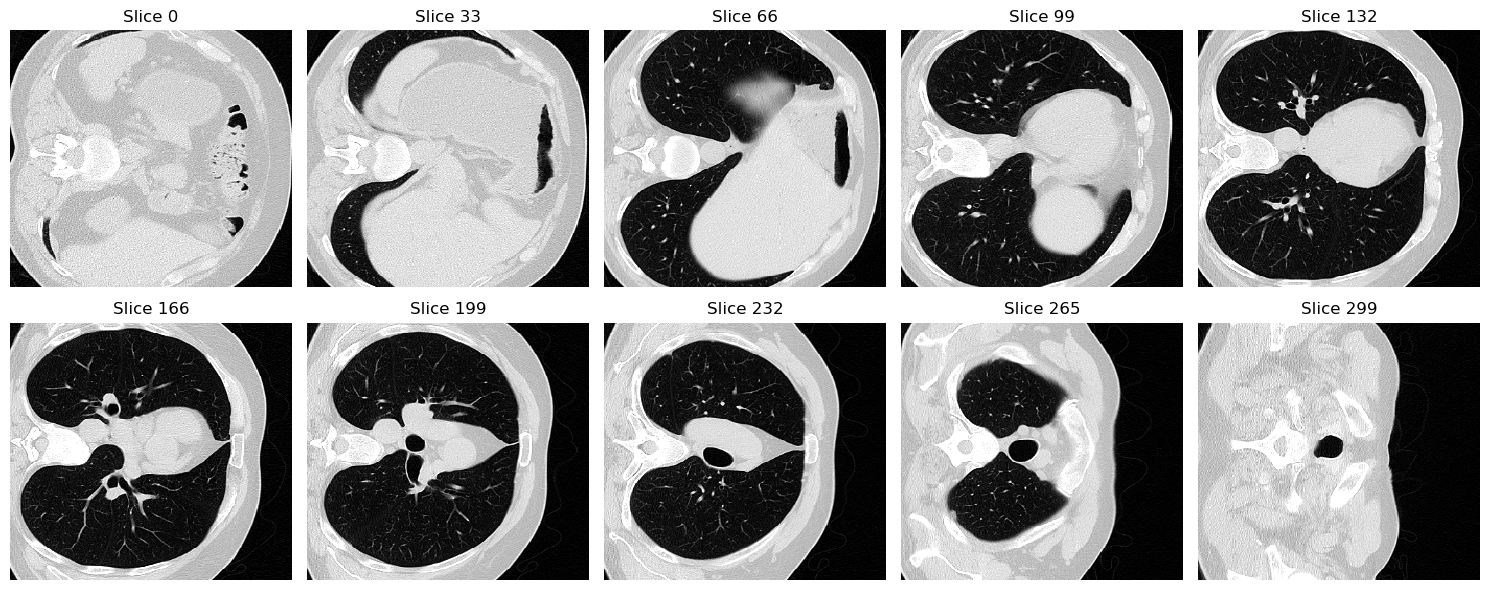

In [5]:
import matplotlib.pyplot as plt

data = None

for batch, target in train_dataloader:
    data = batch[0]
    break

data = data.permute(1, 0, 2, 3) # [1, D, H, W]

s_vol = data[0]
depth = s_vol.shape[0]

print(s_vol.shape)
print(s_vol)

# Select 10 equally spaced indices across the depth axis
n_slices = 10
indices = np.linspace(0, depth - 1, n_slices, dtype=int)

# Plot the selected slices in a grid
cols = 5
rows = (n_slices + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].imshow(s_vol[idx].numpy(), cmap='gray', aspect='auto', interpolation='none')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')
    axes[i].set_frame_on(False)  # Remove subplot border

# Hide unused subplots
for ax in axes[n_slices:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [9]:
from torch.amp import autocast
import numpy as np
from tqdm import tqdm
import gc

# Assume: model, train_loader already defined
best_model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for batch, target in tqdm(train_dataloader):
        with autocast('cuda', enabled=True):
            x, y = batch.cuda(), target.cpu()  # Ensure labels stay on CPU
            emb = best_model.get_embeddings(x).cpu()
            if torch.isnan(emb).any():
                print('Nan!')
                print(y)
                print(x)
                break
            all_embeddings.append(emb)
            all_labels.append(y)

X = torch.cat(all_embeddings).numpy()  # [N, D]
Y = torch.cat(all_labels).numpy()      # [N, C] multilabel binarized vectors


  0%|          | 0/229 [00:10<?, ?it/s]

Nan!
tensor([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0]])
tensor([[[[[  15.7109,    2.4375,   20.1406,  ...,   -1.9863,   -1.9863,
              15.7109],
           [  95.3125,   42.2812,    6.8633,  ...,    2.4375,   42.2812,
              11.2891],
           [  37.8438,   82.0625,  113.0625,  ...,   -1.9863,   15.7109,
              -1.9863],
           ...,
           [  37.8438,   55.5625,   -1.9863,  ...,   59.9688,    6.8633,
              -1.9863],
           [  37.8438,   64.3750,   46.6875,  ...,   -1.9863,   24.5625,
              11.2891],
           [ 117.4375,   37.8438,   28.9844,  ...,   42.2812,    2.4375,
               2.4375]]],


         [[[  28.9844,   11.2891,   20.1406,  ...,   -1.9863,   -1.9863,
               6.8633],
           [ 108.6250,   42.2812,   24.5625,  ...,    2.4375,   28.9844,
              11.2891],
           [  20.1406,

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:

with torch.no_grad():
    best_model.cpu()
    del best_model
    torch.cuda.empty_cache()
    gc.collect()


In [6]:
print(np.sum(Y[:, 0]))
print(np.sum(Y[:, 1]))
print(np.sum(Y[:, 2]))
print(np.sum(Y[:, 3]))

483
525
1020
97


In [7]:

from imblearn.over_sampling import SMOTE, ADASYN
from datasets.base import LabelVectorHelper

helper = LabelVectorHelper()

Y_binarized = np.array([helper.get_class_id(y_vector.tolist()) for y_vector in Y])

oversampler = SMOTE(sampling_strategy={3: 100, 4: 100, 6: 100, 7: 100})  # or ADASYN()
X_res, Y_res = oversampler.fit_resample(X, Y_binarized)

Y_res_vectorized = np.array([helper.get_label_vector(y) for y in Y_res])

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [44]:
print(len([i for i in Y_binarized if i == 0]))
print(len([i for i in Y_binarized if i == 1]))
print(len([i for i in Y_binarized if i == 2]))
print(len([i for i in Y_binarized if i == 3]))
print(len([i for i in Y_binarized if i == 4]))
print(len([i for i in Y_binarized if i == 5]))
print(len([i for i in Y_binarized if i == 6]))
print(len([i for i in Y_binarized if i == 7]))

483
282
753
34
13
217
37
13


In [45]:
print(len([i for i in Y_res if i == 0]))
print(len([i for i in Y_res if i == 1]))
print(len([i for i in Y_res if i == 2]))
print(len([i for i in Y_res if i == 3]))
print(len([i for i in Y_res if i == 4]))
print(len([i for i in Y_res if i == 5]))
print(len([i for i in Y_res if i == 6]))
print(len([i for i in Y_res if i == 7]))

483
282
753
100
100
217
100
100


In [63]:
Y_tensor.shape

torch.Size([2135, 4])

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from losses.losses_local import GradedMicroF1Loss
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Convert back to tensors
X_tensor = torch.from_numpy(X_res).float()
Y_tensor = torch.from_numpy(Y_res_vectorized).float()

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(X_tensor)),
    Y_res,
    stratify=Y_res,
    test_size=0.2,
    random_state=0
)

dataset = TensorDataset(X_tensor, Y_tensor)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

classifier = nn.Sequential(
    nn.Linear(X_tensor.shape[1], 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, Y_tensor.shape[1]),
    nn.Sigmoid()
).cuda()

criterion = GradedMicroF1Loss()  # or BCEWithLogitsLoss, etc.
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

all_logits = []
all_labels = []


# Train classifier on synth and real vector features
classifier.train()
n_epochs = 10
epoch_counter = 0
for epoch in tqdm(range(n_epochs)):
    epoch_counter += 1
    for xb, yb in train_loader:
        xb, yb = xb.cuda(), yb.cuda()
        logits = classifier(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Get post-epoch train loss and label predictions
    with torch.no_grad():
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.cuda(), yb.cuda()
            logits = classifier(xb)
            loss = criterion(logits, yb)
            train_losses.append(loss.item())
            all_logits.append(logits)
            all_labels.append(yb)
        mean_train_loss = np.mean(train_losses)
        print(f'Epoch {epoch_counter}/{n_epochs} training loss: {mean_train_loss:.5f}')
    
    # Get predictions validation loss and label predictions
    with torch.no_grad():
        val_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.cuda(), yb.cuda()
            logits = classifier(xb)
            loss = criterion(logits, yb)
            val_losses.append(loss.item())
            all_logits.append(logits)
            all_labels.append(yb)
        mean_val_loss = np.mean(val_losses)
        print(f'Epoch {epoch_counter}/{n_epochs} validation loss: {mean_val_loss:04f}')



# 
predicted_logits = torch.cat(all_logits).cpu().detach().numpy()  # [N, D]
true_labels = torch.cat(all_labels).cpu().numpy()      # [N, C] multilabel binarized vectors

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


In [73]:
predicted_logits.shape

(2135, 4)

In [74]:
from scipy.special import expit  # numerically stable sigmoid

y_pred_probs = expit(predicted_logits)

In [75]:
y_pred_probs.shape

(2135, 4)

In [84]:
from sklearn.metrics import f1_score, average_precision_score, ndcg_score

# Binarize predictions with threshold 0.5 (adjustable)
y_pred_binary = (y_pred_probs >= 0.5).astype(int)

f1_micro = f1_score(true_labels, y_pred_binary, average='micro')
f1_macro = f1_score(true_labels, y_pred_binary, average='macro')
f1_weighted = f1_score(true_labels, y_pred_binary, average='weighted')

# average_precision_score expects shape [n_samples, n_classes]
# and handles multilabel inputs natively
map_score = average_precision_score(true_labels, y_pred_probs, average='macro')

# ndcg_score expects shape [n_samples, n_classes] and relevance scores
# Use binary relevance (ground truth) and probabilistic ranking
ndcg_at_1 = ndcg_score(true_labels, y_pred_probs, k=1)
ndcg_at_5 = ndcg_score(true_labels, y_pred_probs, k=5)
ndcg_at_10 = ndcg_score(true_labels, y_pred_probs, k=10)


print(f"F1 (micro):    {f1_micro:.4f}")
print(f"F1 (macro):    {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")
print(f"mAP:           {map_score:.4f}")
print(f"NDCG@{1}:      {ndcg_at_1:.4f}")
print(f"NDCG@{5}:      {ndcg_at_5:.4f}")
print(f"NDCG@{10}:      {ndcg_at_10:.4f}")

F1 (micro):    0.4874
F1 (macro):    0.4715
F1 (weighted): 0.5369
mAP:           0.7874
NDCG@1:      0.9527
NDCG@5:      0.9757
NDCG@10:      0.9757


In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
# Add project root to PYTHONPATH
project_root = os.getcwd()
if str(project_root) not in sys.path and project_root.split('/')[-1] == 'chest_ct_retrieval':
    sys.path.append(str(project_root))
elif str(project_root) not in sys.path and project_root.split('/')[-1] == 'notebooks':
    sys.path.append(str(os.path.normpath('/'.join(project_root.split('/')[:-1]))))

%pwd
%cd "E:\\files\\Documents\\Proyecto Proximity\\chest_ct_retrieval"


E:\files\Documents\Proyecto Proximity\chest_ct_retrieval


In [ ]:
import subprocess

%cd "E:\\files\\Documents\\Proyecto Proximity\\chest_ct_retrieval"

process = subprocess.Popen(
    ['python', '-u', 'main.py', '--mode', 'microf1', '--no-optimized-loaders', '--config', 'config/base_local.yaml'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True,
    bufsize=1
)

# Stream output line by line
for line in process.stdout:
    print(line, end='')  # Prevent double newline
process.stdout.close()
process.wait()

E:\files\Documents\Proyecto Proximity\chest_ct_retrieval
CUDA Available: True
Device: cuda:0
Training Mode: microf1
Config: config/base_local.yaml
Optimized Loaders: False
=== MICRO-F1 TRAINING MODE ===

  0%|          | 0/50 [00:00<?, ?it/s]
### EPOCH 1 START ###


  0%|          | 0/192 [00:00<?, ?it/s]outputs: tensor([[ 0.0068, -0.0013, -0.0118, -0.0155],
        [ 0.0454, -0.0021,  0.0103, -0.0085],
        [ 0.0390, -0.0058, -0.0255, -0.0028],
        [ 0.0132, -0.0173, -0.0071,  0.0204],
        [ 0.0250, -0.0464, -0.0029,  0.0330],
        [ 0.0278, -0.0205, -0.0060,  0.0051],
        [ 0.0312, -0.0138,  0.0186, -0.0053],
        [ 0.0030, -0.0395,  0.0005, -0.0244],
        [ 0.0210, -0.0498,  0.0099,  0.0298]], device='cuda:0',
       dtype=torch.float16, grad_fn=<AddmmBackward0>)
target: tensor([[0, 1, 1, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 1, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 0, 1, 0],
        [0, 0, 

In [ ]:
import torch
from config.config import load_config
from utils.seed import set_seed
from training.setup import setup_training_run
from training.environment import configure_environment
from eval.metric_loader import load_metrics
from training.data_setup_local import load_dataset_microf1, create_loaders_microf1
from training.model_setup_local import initialize_model_micro_f1
from training.trainer_local_microf1 import Trainer


cuda_available = torch.cuda.is_available()

cfg = load_config("config/base_local.yaml")

set_seed(cfg["training"]["seed"])

run_dirs = setup_training_run(cfg["paths"]["dr2156"]["microf1_runs"])

checkpoints_dir = run_dirs["checkpoints"]
tensorboard_dir = run_dirs["logs"]

configure_environment(cfg)

train_set, test_set, neg_compatibles = load_dataset_microf1(
    cfg["paths"]["dr2156"]["preprocessed_300_int8"], 
    cfg["training"]["seed"], 
    float(cfg["dataset"]["train_frac"]),
    augmentations_arg=cfg["training"]["augmentations"]
)

### MODELO MICRO-F1
p_model, p_loss_fn, p_optimizer, p_scheduler = initialize_model_micro_f1(
    embedding_size=int(cfg["model"]["embedding_size"]),
    lr=float(cfg["training"]["optimizer"]["lr"]),
    weight_decay=float(cfg["training"]["optimizer"]["weight_decay"]),
    cuda=cuda_available
)

loaders = create_loaders_microf1(
    train_set,
    test_set,
    cfg["training"]["batch"]["batch_size"],
    cuda_available
)

p_metrics = load_metrics(cfg)

## MICRO-F1 TRAINING
trainer = Trainer(
    train_loader=loaders["train"],
    val_loader=loaders["test"],
    model=p_model,
    loss_fn=p_loss_fn,
    optimizer=p_optimizer,
    scheduler=p_scheduler,
    n_epochs=cfg["training"]["n_epochs"],
    cuda=cuda_available,
    log_interval=cfg["logging"]["log_interval"],
    checkpoint_dir=checkpoints_dir,
    tensorboard_logs_dir=tensorboard_dir,
    metrics=p_metrics,
    start_epoch=0,
    accumulation_steps=3
)
trainer.fit()


  0%|          | 0/50 [00:00<?, ?it/s]


### EPOCH 1 START ###


  0%|          | 0/288 [00:00<?, ?it/s]

Batch 0/288: Loss = 0.202157
Batch 10/288: Loss = 0.202830


In [2]:
import torch
from config.config import load_config
from utils.seed import set_seed
from training.setup import setup_training_run
from training.environment import configure_environment
from eval.metric_loader import load_metrics

from training.data_setup_local import load_dataset_microf1, create_loaders_microf1
from training.model_setup_local import initialize_model_micro_f1
from training.trainer_local_microf1 import Trainer

print("=== MICRO-F1 TRAINING MODE ===")

# Detect Jupyter environment if not specified

# Setup directories

cuda_available = torch.cuda.is_available()

cfg = load_config("config/base_local.yaml")

run_dirs = setup_training_run(cfg["paths"]["dr2156"]["microf1_runs"])
checkpoints_dir = run_dirs["checkpoints"]
tensorboard_dir = run_dirs["logs"]

# Load dataset with device parameter
train_set, test_set, neg_compatibles = load_dataset_microf1(
    cfg["paths"]["dr2156"]["preprocessed_300_int8"], 
    cfg["training"]["seed"], 
    float(cfg["dataset"]["train_frac"]),
    augmentations_arg=cfg["training"]["augmentations"]
)

# Initialize model
p_model, p_loss_fn, p_optimizer, p_scheduler = initialize_model_micro_f1(
    embedding_size=int(cfg["model"]["embedding_size"]),
    lr=float(cfg["training"]["optimizer"]["lr"]),
    weight_decay=float(cfg["training"]["optimizer"]["weight_decay"]),
    cuda=cuda_available
)


loaders = create_loaders_microf1(
    train_set, 
    test_set, 
    cfg["training"]["batch"]["batch_size"],
    cuda_available
)

# Load metrics
p_metrics = load_metrics(cfg)

=== MICRO-F1 TRAINING MODE ===


In [3]:
p_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
s_vol, s_label = train_set[4]
s_tensor = torch.tensor(s_vol.copy()).cuda()
output = p_model(s_tensor)

In [ ]:
output

tensor([[ 0.0271,  0.0182, -0.0008, -0.0214]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [5]:
s_label

2

In [8]:
tio_image['data'][0].shape

torch.Size([1, 150, 150])

(1, 300, 150, 150)
[[[[1.87   1.651  1.731  ... 1.513  1.795  1.843 ]
   [1.874  1.512  1.782  ... 1.644  1.548  1.802 ]
   [1.731  1.961  1.587  ... 1.788  1.764  1.785 ]
   ...
   [1.657  1.586  1.736  ... 1.798  1.71   1.725 ]
   [1.729  1.758  1.476  ... 1.8125 1.595  1.502 ]
   [1.738  1.799  1.679  ... 1.643  1.768  1.761 ]]

  [[1.626  1.94   1.824  ... 1.558  1.587  1.571 ]
   [1.789  1.573  2.041  ... 2.012  1.566  1.686 ]
   [1.861  1.624  1.86   ... 1.568  1.76   1.78  ]
   ...
   [1.651  1.646  1.663  ... 1.751  1.729  1.62  ]
   [1.564  1.674  1.542  ... 1.716  1.518  1.691 ]
   [1.6875 1.779  1.686  ... 1.712  1.573  1.742 ]]

  [[1.74   1.741  1.685  ... 1.586  1.878  1.629 ]
   [1.647  1.722  1.541  ... 1.504  1.722  1.706 ]
   [1.721  1.715  1.734  ... 1.763  1.81   1.421 ]
   ...
   [1.617  1.818  1.723  ... 2.006  1.842  1.686 ]
   [1.771  1.65   1.738  ... 1.756  1.733  1.609 ]
   [1.631  1.817  1.584  ... 1.858  1.656  1.573 ]]

  ...

  [[1.692  1.717  1.451  ... 

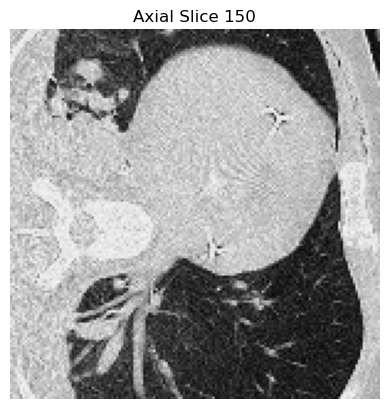

In [19]:
s_vol, s_label = train_set[2]

s_vol = np.transpose(s_vol, axes=[1, 0, 2, 3]) # transpose [D, 1, H, W] to [1, D, H, W]

import matplotlib.pyplot as plt
import torchio as tio
import numpy as np

print(s_vol.shape)
print(s_vol)


resize = tio.Compose([
            #tio.Resize([100, 100, -1], image_interpolation='nearest'),
            tio.RescaleIntensity(out_min_max=(0,1))
        ])

tio_image = tio.ScalarImage(tensor=s_vol.copy(), affine=np.eye(4))
tio_image = resize(tio_image)                

s_vol = tio_image['data'][0]           # remove channel dimension → shape: [D, H, W]

#print(s_vol.shape)
#print(s_vol)

# Select middle slice in the axial (transverse) plane → [z, y, x]
z_index = s_vol.shape[0] // 2
axial_slice = s_vol[120, :, :]

# Plot
plt.imshow(axial_slice.numpy(), cmap='gray')
plt.title(f'Axial Slice {z_index}')
plt.axis('off')
plt.show()


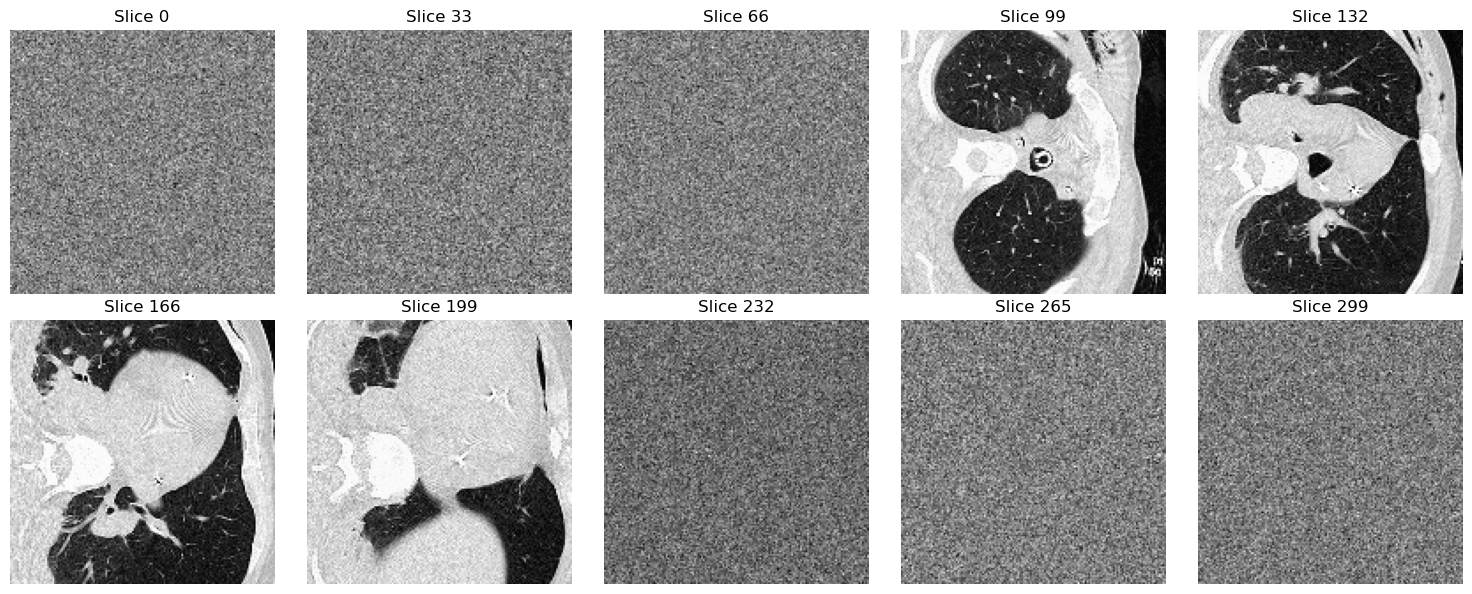

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torchio as tio

s_vol, s_label = train_set[2]

s_vol = np.transpose(s_vol, axes=[1, 0, 2, 3]) # transpose [D, 1, H, W] to [1, D, H, W]

# Get the 3D volume from the TorchIO subject
resize = tio.Compose([
            #tio.Resize([100, 100, -1], image_interpolation='nearest'),
            tio.RescaleIntensity(out_min_max=(0,1))
        ])

tio_image = tio.ScalarImage(tensor=s_vol.copy(), affine=np.eye(4))
tio_image = resize(tio_image)                

s_vol = tio_image['data'][0]           # remove channel dimension → shape: [D, H, W]

depth = s_vol.shape[0]

# Select 10 equally spaced indices across the depth axis
n_slices = 10
indices = np.linspace(0, depth - 1, n_slices, dtype=int)

# Plot the selected slices in a grid
cols = 5
rows = (n_slices + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].imshow(s_vol[idx].numpy(), cmap='gray')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

# Hide unused subplots
for ax in axes[n_slices:]:
    ax.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
del tensor, model, subject  # or any other large variables
import gc
gc.collect()
import torch
torch.cuda.empty_cache()